## Set up

In [47]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## EDA + Cleaning

In [31]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

In [32]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [33]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [34]:
fake_df["Target"] = 1
true_df["Target"] = 0
combined_news = pd.concat([fake_df, true_df], ignore_index = True)
combined_news

,title,text,subject,date,Target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0


In [64]:
fake_df['title'].apply(len).mean()

94.19803245176952

In [63]:
true_df['title'].apply(len).mean()

64.667880655554

Text(0.5, 1.0, 'Target variable count')

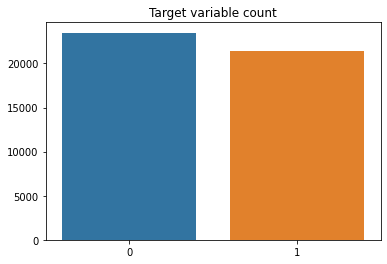

In [35]:
count = combined_news['Target'].value_counts().values
sns.barplot(x = [0,1], y = count)
plt.title('Target variable count')

The dataset seems to be relatively even given that there are between 0 and 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

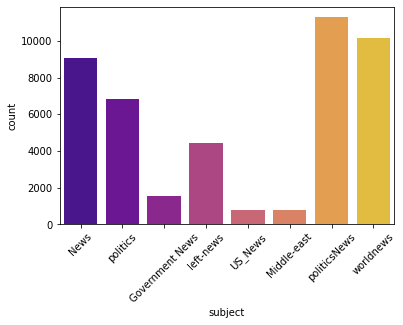

In [36]:
sns.countplot(combined_news.subject,palette='plasma')
plt.xticks(rotation=45)

In [37]:
combined_news['text'] = combined_news['title'] + " " + combined_news['text']

In [38]:
combined_news.drop(columns = ['title','subject','date'])

,text,Target
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,0
44894,LexisNexis withdrew two products from Chinese ...,0
44895,Minsk cultural hub becomes haven from authorit...,0
44896,Vatican upbeat on possibility of Pope Francis ...,0


In [39]:

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    text = text.lower()
    for i in text.split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def clean_text(text):
    text = remove_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text


In [40]:
combined_news['text']=combined_news['text'].apply(clean_text)
combined_news['text']

0        donald trump sends embarrassing new year’s eve...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes internet joke thr...
3        trump obsessed even obama’s name coded website...
4        pope francis called donald trump christmas spe...
                               ...                        
44893    'fully committed' nato backs new u.s. approach...
44894    lexisnexis withdrew two products chinese marke...
44895    minsk cultural hub becomes authorities minsk (...
44896    vatican upbeat possibility pope francis visiti...
44897    indonesia buy $1.14 billion worth russian jets...
Name: text, Length: 44898, dtype: object

In [41]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    token_words=word_tokenize(text) 
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

In [48]:
combined_news['text']=combined_news['text'].apply(lemmatize_text)
combined_news

,title,text,subject,date,Target
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new year ’ s e...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...,News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump obsessed even obama ’ s name coded websi...,News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis called donald trump christmas spe...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,'fully committed ' nato back new u.s. approach...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,lexisnexis withdrew two product chinese market...,worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,minsk cultural hub becomes authority minsk ( r...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,vatican upbeat possibility pope francis visiti...,worldnews,"August 22, 2017",0


## Training and Testing

In [50]:
x = combined_news['text']
y = combined_news['Target']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state= 0)

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

In [52]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train,y_train)
pred_lr=LR.predict(xv_test)
LR.score(xv_test, y_test)

0.988641425389755

In [55]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)
pred_dt = DT.predict(xv_test)
DT.score(xv_test, y_test)


0.9957683741648107

In [56]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)
pred_rfc = RFC.predict(xv_test)
RFC.score(xv_test, y_test)


0.9927616926503341